In [1]:
import os


In [2]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
Vld_Splt= 0.0909
batch_size = 200
num_classes = 10
epochs = 30

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [6]:
print(y_train.shape, '\n',y_test.shape,'\n',
      x_train.shape,'\n', x_test.shape)

(50000, 10) 
 (10000, 10) 
 (50000, 32, 32, 3) 
 (10000, 32, 32, 3)


In [7]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [8]:
"""one-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_0 = Conv2D(filters= 220, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_0= Dropout(0.1)(x_0)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_0 = Reshape((-1, 220))(x_0)
capsule_0 = Capsule(num_classes, 16, 3, True)(x_0)
output_0 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_0)
model_0 = Model(inputs= input_image, outputs= output_0)

# we use a margin loss
model_0.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_0.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 220)       16720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 220)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784, 220)          0         
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 16)            35200     
_________________________________________________________________
lambda_1 (Lambda)    

In [9]:
"""two-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_1 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_1= Dropout(0.1)(x_1)
x_1 = Conv2D(filters= 95, kernel_size= 5, activation='relu',
             strides= 1)(x_1)
x_1 = Dropout(0.1)(x_1)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_1 = Reshape((-1, 95))(x_1)
capsule_1 = Capsule(num_classes, 16, 3, True)(x_1)
output_1 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_1)
model_1= Model(inputs= input_image, outputs= output_1)

# we use a margin loss
model_1.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_1.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 15)        1140      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 95)        35720     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 95)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 576, 95)           0         
_________________________________________________________________
capsule_2 (Capsule)          (None, 10, 16)            15200     
__________

In [10]:
"""three-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_2 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_2= Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 30, kernel_size= 5, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 45, kernel_size= 5, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_2 = Reshape((-1, 45))(x_2)
capsule_2 = Capsule(num_classes, 16, 3, True)(x_2)
output_2 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_2)
model_2= Model(inputs= input_image, outputs= output_2)

# we use a margin loss
model_2.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_2.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 15)        1140      
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 30)        11280     
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 45)        33795     
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 20, 45)        0         
__________

In [70]:
"""four-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_3 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 25 ,kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3 = Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 27, kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 30,kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_3 = Reshape((-1, 30))(x_3)
capsule_3 = Capsule(num_classes, 16, 3, True)(x_3)
output_3 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_3)
model_3= Model(inputs= input_image, outputs= output_3)

# we use a margin loss
model_3.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_3.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 15)        1140      
_________________________________________________________________
dropout_54 (Dropout)         (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 24, 24, 25)        9400      
_________________________________________________________________
dropout_55 (Dropout)         (None, 24, 24, 25)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 20, 20, 27)        16902     
_________________________________________________________________
dropout_56 (Dropout)         (None, 20, 20, 27)        0         
__________

In [71]:
"""five-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_4 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 20 ,kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4 = Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 20, kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
              strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 32,kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_4 = Reshape((-1, 32))(x_4)
capsule_4 = Capsule(num_classes, 16, 3, True)(x_4)
output_4 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_4)
model_4= Model(inputs= input_image, outputs= output_4)

# we use a margin loss
model_4.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_4.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 28, 28, 15)        1140      
_________________________________________________________________
dropout_58 (Dropout)         (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 24, 24, 20)        7520      
_________________________________________________________________
dropout_59 (Dropout)         (None, 24, 24, 20)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 20, 20, 20)        10020     
_________________________________________________________________
dropout_60 (Dropout)         (None, 20, 20, 20)        0         
__________

In [42]:
"""six-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_5 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 15 ,kernel_size= 5, activation='relu',
             padding= 'same')(x_5)
x_5 = Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 15, kernel_size= 5, activation='relu',
             strides= 2)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             padding= 'same')(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 30,kernel_size= 5, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_5 = Reshape((-1, 30))(x_5)
capsule_5 = Capsule(num_classes, 16, 3, True)(x_5)
output_5 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_5)
model_5= Model(inputs= input_image, outputs= output_5)

# we use a margin loss
model_5.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_5.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 15)        1140      
_________________________________________________________________
dropout_31 (Dropout)         (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 15)        5640      
_________________________________________________________________
dropout_32 (Dropout)         (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 12, 15)        5640      
_________________________________________________________________
dropout_33 (Dropout)         (None, 12, 12, 15)        0         
__________

In [14]:
"""seven-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_6 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 15 ,kernel_size= 5, activation='relu',
            padding= 'same')(x_6)
x_6 = Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 15, kernel_size= 5, activation='relu',
              strides= 2)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
              padding= 'same')(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
             padding= 'same')(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
              strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_6 = Reshape((-1, 25))(x_6)
capsule_6 = Capsule(num_classes, 16, 3, True)(x_6)
output_6 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_6)
model_6= Model(inputs= input_image, outputs= output_6)

# we use a margin loss
model_6.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_6.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 15)        1140      
_________________________________________________________________
dropout_22 (Dropout)         (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 15)        5640      
_________________________________________________________________
dropout_23 (Dropout)         (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 15)        5640      
_________________________________________________________________
dropout_24 (Dropout)         (None, 12, 12, 15)        0         
__________

In [15]:
"""CNN-3-CONV-LAYERS"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, \
                         ZeroPadding2D

model_7= Sequential()
model_7.add(Conv2D(filters= 5, kernel_size= (5, 5), padding= 'same', 
                   input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), 
                   activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2,2)))
model_7.add(Conv2D(filters= 13, kernel_size= (5, 5), 
                    padding= 'valid', activation='relu'))
model_7.add(Dropout(0.3))
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Flatten())
model_7.add(Dropout(0.4))
model_7.add(Dense(256, activation='relu'))
model_7.add(Dense(num_classes, activation='softmax'))
print(model_7.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 5)         380       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 13)        1638      
_________________________________________________________________
dropout_29 (Dropout)         (None, 12, 12, 13)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 13)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 468)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 468)               0         
__________

In [16]:
"""one-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_0= model_0.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_0= model_0.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 20s 451us/step - loss: 0.6799 - acc: 0.2385 - val_loss: 0.4532 - val_acc: 0.3050
Epoch 2/30
45455/45455 [==============================] - 18s 398us/step - loss: 0.4450 - acc: 0.3272 - val_loss: 0.4285 - val_acc: 0.3536
Epoch 3/30
45455/45455 [==============================] - 18s 404us/step - loss: 0.4262 - acc: 0.3639 - val_loss: 0.4196 - val_acc: 0.3765
Epoch 4/30
45455/45455 [==============================] - 18s 404us/step - loss: 0.4184 - acc: 0.3802 - val_loss: 0.4034 - val_acc: 0.4073
Epoch 5/30
45455/45455 [==============================] - 18s 404us/step - loss: 0.4112 - acc: 0.3944 - val_loss: 0.4303 - val_acc: 0.3593
Epoch 6/30
45455/45455 [==============================] - 18s 407us/step - loss: 0.4052 - acc: 0.4103

In [17]:
"""two-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_1= model_1.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_1= model_1.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 12s 267us/step - loss: 0.5279 - acc: 0.3179 - val_loss: 0.4137 - val_acc: 0.4026
Epoch 2/30
45455/45455 [==============================] - 15s 336us/step - loss: 0.3826 - acc: 0.4540 - val_loss: 0.3748 - val_acc: 0.4493
Epoch 3/30
45455/45455 [==============================] - 12s 254us/step - loss: 0.3584 - acc: 0.4962 - val_loss: 0.3498 - val_acc: 0.5146
Epoch 4/30
45455/45455 [==============================] - 11s 252us/step - loss: 0.3417 - acc: 0.5261 - val_loss: 0.3292 - val_acc: 0.5474
Epoch 5/30
45455/45455 [==============================] - 17s 364us/step - loss: 0.3313 - acc: 0.5449 - val_loss: 0.3274 - val_acc: 0.5549
Epoch 6/30
45455/45455 [==============================] - 11s 252us/step - loss: 0.3216 - acc: 0.5630 - val_loss: 0.3154 - val_acc: 0.5714
Epoch 7/30
45455/45455 [==============================] - 11s 249us/step - loss: 0.3145 

In [18]:
"""three-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_2= model_2.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_2= model_2.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 10s 220us/step - loss: 0.4821 - acc: 0.2787 - val_loss: 0.4171 - val_acc: 0.3573
Epoch 2/30
45455/45455 [==============================] - 9s 202us/step - loss: 0.4023 - acc: 0.3939 - val_loss: 0.3803 - val_acc: 0.4429
Epoch 3/30
45455/45455 [==============================] - 9s 202us/step - loss: 0.3658 - acc: 0.4675 - val_loss: 0.3578 - val_acc: 0.4856
Epoch 4/30
45455/45455 [==============================] - 14s 298us/step - loss: 0.3417 - acc: 0.5141 - val_loss: 0.3457 - val_acc: 0.5003
Epoch 5/30
45455/45455 [==============================] - 9s 202us/step - loss: 0.3274 - acc: 0.5379 - val_loss: 0.3268 - val_acc: 0.5362
Epoch 6/30
45455/45455 [==============================] - 9s 203us/step - loss: 0.3156 - acc: 0.5598 - val_loss: 0.3092 - val_acc: 0.5688
Epoch 7/30
45455/45455 [==============================] - 9s 203us/step - loss: 0.3036 - acc

In [72]:
"""four-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_3= model_3.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_3= model_3.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 10s 217us/step - loss: 0.4960 - acc: 0.2507 - val_loss: 0.4439 - val_acc: 0.3184
Epoch 2/30
45455/45455 [==============================] - 8s 177us/step - loss: 0.4074 - acc: 0.3877 - val_loss: 0.3817 - val_acc: 0.4361
Epoch 3/30
45455/45455 [==============================] - 8s 181us/step - loss: 0.3693 - acc: 0.4646 - val_loss: 0.3616 - val_acc: 0.4858
Epoch 4/30
45455/45455 [==============================] - 8s 180us/step - loss: 0.3427 - acc: 0.5103 - val_loss: 0.3333 - val_acc: 0.5316
Epoch 5/30
45455/45455 [==============================] - 8s 183us/step - loss: 0.3210 - acc: 0.5475 - val_loss: 0.3089 - val_acc: 0.5659
Epoch 6/30
45455/45455 [==============================] - 8s 174us/step - loss: 0.3067 - acc: 0.5690 - val_loss: 0.3025 - val_acc: 0.5674
Epoch 7/30
45455/45455 [==============================] - 8s 173us/step - loss: 0.2958 - acc:

In [73]:
"""five-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_4= model_4.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_4= model_4.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 9s 201us/step - loss: 0.4873 - acc: 0.2267 - val_loss: 0.4356 - val_acc: 0.3069
Epoch 2/30
45455/45455 [==============================] - 7s 157us/step - loss: 0.4119 - acc: 0.3686 - val_loss: 0.3922 - val_acc: 0.4090
Epoch 3/30
45455/45455 [==============================] - 7s 153us/step - loss: 0.3725 - acc: 0.4477 - val_loss: 0.3547 - val_acc: 0.4735
Epoch 4/30
45455/45455 [==============================] - 7s 160us/step - loss: 0.3441 - acc: 0.4936 - val_loss: 0.3240 - val_acc: 0.5261
Epoch 5/30
45455/45455 [==============================] - 7s 156us/step - loss: 0.3224 - acc: 0.5304 - val_loss: 0.3110 - val_acc: 0.5413
Epoch 6/30
45455/45455 [==============================] - 7s 155us/step - loss: 0.3074 - acc: 0.5540 - val_loss: 0.3060 - val_acc: 0.5586
Epoch 7/30
45455/45455 [==============================] - 8s 165us/step - loss: 0.2967 - acc: 

In [67]:
"""six-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_5= model_5.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_5= model_5.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 5s 107us/step - loss: 0.2033 - acc: 0.7115 - val_loss: 0.2081 - val_acc: 0.7012
Epoch 2/30
45455/45455 [==============================] - 5s 107us/step - loss: 0.2034 - acc: 0.7125 - val_loss: 0.2082 - val_acc: 0.6999
Epoch 3/30
45455/45455 [==============================] - 5s 108us/step - loss: 0.1997 - acc: 0.7169 - val_loss: 0.2118 - val_acc: 0.6915
Epoch 4/30
45455/45455 [==============================] - 5s 109us/step - loss: 0.1982 - acc: 0.7226 - val_loss: 0.2065 - val_acc: 0.7028
Epoch 5/30
45455/45455 [==============================] - 5s 104us/step - loss: 0.1982 - acc: 0.7208 - val_loss: 0.2152 - val_acc: 0.6876
Epoch 6/30
45455/45455 [==============================] - 5s 104us/step - loss: 0.1968 - acc: 0.7211 - val_loss: 0.2057 - val_acc: 0.7054
Epoch 7/30
45455/45455 [==============================] - 5s 108us/step - loss: 0.1941 - acc: 

In [68]:
"""seven-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_6= model_6.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_6= model_6.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 6s 124us/step - loss: 0.1618 - acc: 0.7745 - val_loss: 0.1841 - val_acc: 0.7426
Epoch 2/30
45455/45455 [==============================] - 5s 117us/step - loss: 0.1632 - acc: 0.7729 - val_loss: 0.1895 - val_acc: 0.7338
Epoch 3/30
45455/45455 [==============================] - 5s 117us/step - loss: 0.1626 - acc: 0.7748 - val_loss: 0.1846 - val_acc: 0.7355
Epoch 4/30
45455/45455 [==============================] - 5s 115us/step - loss: 0.1621 - acc: 0.7739 - val_loss: 0.1816 - val_acc: 0.7468
Epoch 5/30
45455/45455 [==============================] - 5s 116us/step - loss: 0.1614 - acc: 0.7753 - val_loss: 0.1828 - val_acc: 0.7435
Epoch 6/30
45455/45455 [==============================] - 5s 113us/step - loss: 0.1617 - acc: 0.7754 - val_loss: 0.1804 - val_acc: 0.7459
Epoch 7/30
45455/45455 [==============================] - 5s 115us/step - loss: 0.1597 - acc: 

In [23]:
"""CNN-3-CONV-LAYERS"""
model_7.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
train_history_7= model_7.fit(x= x_train, y= y_train, validation_split= Vld_Splt,
                         epochs= epochs, batch_size= batch_size, verbose=1)

Train on 45455 samples, validate on 4545 samples
Epoch 1/30
45455/45455 [==============================] - 4s 82us/step - loss: 1.8305 - acc: 0.3295 - val_loss: 1.6069 - val_acc: 0.4279
Epoch 2/30
45455/45455 [==============================] - 3s 62us/step - loss: 1.5479 - acc: 0.4398 - val_loss: 1.4480 - val_acc: 0.4988
Epoch 3/30
45455/45455 [==============================] - 3s 59us/step - loss: 1.4570 - acc: 0.4788 - val_loss: 1.4093 - val_acc: 0.5155
Epoch 4/30
45455/45455 [==============================] - 3s 59us/step - loss: 1.4097 - acc: 0.4946 - val_loss: 1.3472 - val_acc: 0.5441
Epoch 5/30
45455/45455 [==============================] - 3s 58us/step - loss: 1.3642 - acc: 0.5106 - val_loss: 1.2937 - val_acc: 0.5593
Epoch 6/30
45455/45455 [==============================] - 3s 58us/step - loss: 1.3277 - acc: 0.5291 - val_loss: 1.2729 - val_acc: 0.5705
Epoch 7/30
45455/45455 [==============================] - 3s 61us/step - loss: 1.2955 - acc: 0.5400 - val_loss: 1.2427 - val_acc:

In [74]:
"""one-CONV-LAYERS-THICK"""
scores_0= model_0.evaluate(x_test, y_test)
scores_0[1]

10000/10000 [==============================] - 2s 162us/step


0.506

In [75]:
"""two-CONV-LAYERS-THICK"""
scores_1= model_1.evaluate(x_test, y_test)
scores_1[1]

10000/10000 [==============================] - 1s 148us/step


0.647

In [76]:
"""three-CONV-LAYERS-THICK"""
scores_2= model_2.evaluate(x_test, y_test)
scores_2[1]

10000/10000 [==============================] - 1s 137us/step


0.6811

In [77]:
"""four-CONV-LAYERS-THICK"""
scores_3= model_3.evaluate(x_test, y_test)
scores_3[1]

10000/10000 [==============================] - 1s 144us/step


0.683

In [78]:
"""five-CONV-LAYERS-THICK"""
scores_4= model_4.evaluate(x_test, y_test)
scores_4[1]

10000/10000 [==============================] - 1s 128us/step


0.6801

In [79]:
"""six-CONV-LAYERS-THICK"""
scores_5= model_5.evaluate(x_test, y_test)
scores_5[1]

10000/10000 [==============================] - 1s 123us/step


0.7278

In [80]:
"""seven-CONV-LAYERS-THICK"""
scores_6= model_6.evaluate(x_test, y_test)
scores_6[1]

10000/10000 [==============================] - 1s 119us/step


0.758

In [81]:
"""CNN"""
scores_7= model_7.evaluate(x_test, y_test)
scores_7[1]

10000/10000 [==============================] - 1s 88us/step


0.6459

In [82]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

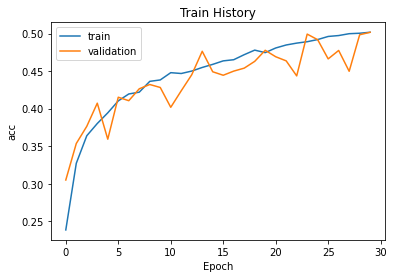

In [83]:
show_train_history(train_history_0, 'acc', 'val_acc')

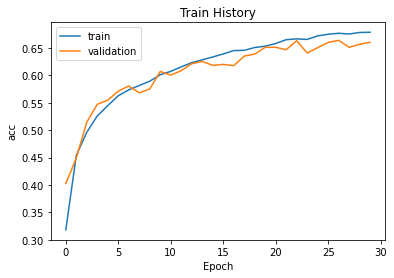

In [84]:
show_train_history(train_history_1, 'acc', 'val_acc')

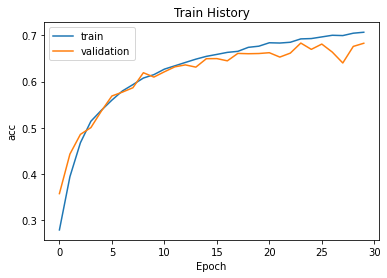

In [85]:
show_train_history(train_history_2, 'acc', 'val_acc')

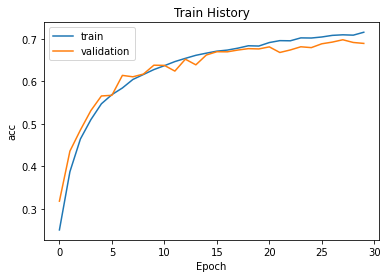

In [86]:
show_train_history(train_history_3, 'acc', 'val_acc')

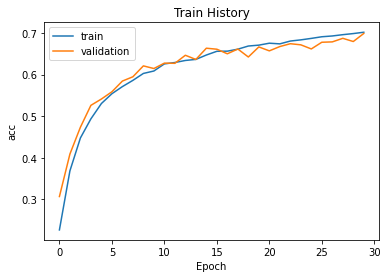

In [87]:
show_train_history(train_history_4, 'acc', 'val_acc')

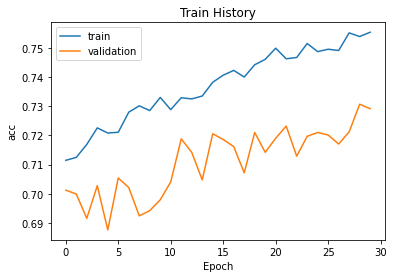

In [88]:
show_train_history(train_history_5, 'acc', 'val_acc')

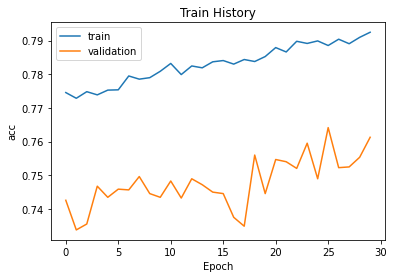

In [89]:
show_train_history(train_history_6, 'acc', 'val_acc')

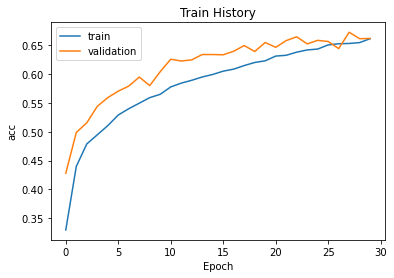

In [90]:
show_train_history(train_history_7, 'acc', 'val_acc')

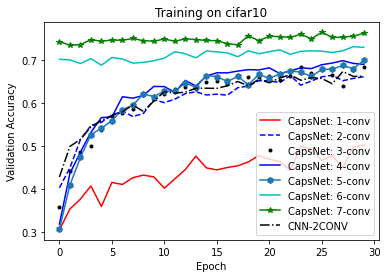

In [91]:
plt.plot(train_history_0.history['val_acc'], 'r-')
plt.plot(train_history_1.history['val_acc'], 'b--')
plt.plot(train_history_2.history['val_acc'], 'k.')
plt.plot(train_history_3.history['val_acc'], 'b-')
plt.plot(train_history_4.history['val_acc'], 'h-')
plt.plot(train_history_5.history['val_acc'], 'c-')
plt.plot(train_history_6.history['val_acc'], 'g*-')
plt.plot(train_history_7.history['val_acc'], 'k-.')
plt.title('Training on cifar10')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['CapsNet: 1-conv','CapsNet: 2-conv','CapsNet: 3-conv','CapsNet: 4-conv','CapsNet: 5-conv','CapsNet: 6-conv',
           'CapsNet: 7-conv','CNN-2CONV'], loc='best')
plt.show()